In [ ]:
# default_exp cnn_oc_svm

# cnn_oc_svm

> Contains the base class for the CNN OC-SVM model. Override the SVM or CNN as desired but used directly is optimized for the MNIST example case.

In [ ]:
# hide
from nbdev.showdoc import *

%load_ext lab_black

In [ ]:
# export
import numpy as np
import copy
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
import time
from pathlib import Path
from typing import List
from sklearn.svm import OneClassSVM


class cnn_oc_svm:
    """
    The base-class for building a neural network with oc-SVM.
    """

    def __init__(self, neural_net, criterion, optimizer):
        self.neural_net = neural_net
        self.criterion = criterion
        self.optimizer = optimizer

        self.original_transforms = None
        self.oc_svm = None

    def training(self, epochs, learning_rate, training_data_loader, *args, **kwargs):
        """
        Basic training function for nn.Sequence style models.
        """
        start_time = time.time()
        for epoch in range(1, epochs + 1):
            running_loss = 0
            for images, labels in training_data_loader:
                images = images.view(images.shape[0], -1)

                optimizer.zero_grad()

                predicted_labels = self.neural_net(images)
                loss = self.criterion(predicted_labels, labels)

                loss.backward()

                optimizer.step()

                running_loss += loss.item()

            else:
                print(
                    f"Epoch {epoch} - Training loss: {running_loss/len(training_data_loader)}"
                )

        print(f"Training time (s): {time.time()-start_time}")
        return running_loss / len(training_data_loader)

    def evaluation(self, validation_data_loader):
        """
        Simple evaluation function to check neural network accuracy
        """
        correct_classification, total_count = 0, 0
        for images, labels in validation_data_loader:
            for i in range(len(labels)):
                img = images[i].view(1, 784)

                with torch.no_grad():  # no grad because we are evaluation mode! using .eval() might work too
                    log_probabilities = model(img)
                probabilities = list(torch.exp(log_probabilities).numpy()[0])

                predicted_label = probabilities.index(max(probabilities))
                true_label = labels.numpy()[i]

                if predicted_label == true_label:
                    correct_classification += 1

                total_count += 1
        print(
            f"Images tested: {total_count} \n Classification Accuracy: {correct_classification/total_count}"
        )
        return correct_classification / total_count

    def train_oc_svm(self, training_data_loader, amount_to_train_on=None):

        start_time = time.time()

        image_to_feature_transform = self.neural_net[:-2].eval()
        # load up our to numpy and image to feature vector transforms
        oc_svm_data_transforms = transforms.Compose(
            [
                lambda x: x.view(-1, 28 ** 2),
                lambda x: image_to_feature_transform(x),
                lambda x: x.detach().numpy(),
                lambda x: x.flatten(),
            ]
        )

        training_data = list()
        if amount_to_train_on == None:
            amount_to_train_on = len(training_data_loader.dataset)
        while len(training_data) < amount_to_train_on:
            image, _ = next(iter(training_data_loader))
            training_data.extend([oc_svm_data_transforms(im) for im in image])
        training_data = np.array(training_data)

        self.oc_svm = OneClassSVM()
        print(f"Fitting One Class SVM on {len(training_data)} data points")
        self.oc_svm.fit(training_data)

        if self.oc_svm.fit_status_ != 0:
            print(f"OC SVM incorrectly fitted, try refitting?")
        else:
            print(f"OC SVM Sucessfully fit, training time: {time.time()-start_time}")

    def predict_if_outlier(self, predict_data_loader):
        image_to_feature_transform = self.neural_net[:-2].eval()

        oc_svm_data_transforms = transforms.Compose(
            [
                lambda x: x.view(-1, 28 ** 2),
                lambda x: image_to_feature_transform(x),
                lambda x: x.detach().numpy(),
                lambda x: x.flatten(),
            ]
        )
        predictions = list()
        for image in next(iter(predict_data_loader))[0]:
            predictions.extend([oc_svm_data_transforms(im) for im in image])
        results = self.oc_svm.predict(predictions)
        return results

    def __repr__(self):
        return self.neural_net.__repr__()

### Basic neural net for Fashion MNIST pictures
Let's build a quick neural net in pytorch to classify clothes from Fashion MNIST. I'm assuming if you're this far deep into machine learning, you likely have encountered this before. If you are unsure about the basics of Neural Networks as classifiers, you should check out an in depth tutorial for the nitty-gritty details. We're doing this in a standard but terse approach.

### The general idea:

In training a neural network we are transforming images into feature maps and feeding that into the final fully connected layer that corresponds to our classes. Once we have a model with the performance we like, we separate the final layer from the rest of the neural net. We then use this feature extractor on our training set to generate our training data for the one-class SVM.

Why do we care? Because then we can do this on incoming data and check if the incoming image data is anomalous. Depending on your use case this can mean auto-flagging useful and novel future training data or could mean flagging potentially fraudulent or dangerous input.

This will be demonstrated with a fashion MNIST classifier with the hope to have the OC-SVM flag input images that are not clothes (noise, patterns, or non-clothing objects like cats).

### Steps:

1. Load up Fashion MNIST dataset and setup data pipeline
2. Construct Fully Connected Neural Net in pytorch and train
3. Freeze model and separate the last fully connected layer from model
    * Ideally we can pass the vector straight to the last layer
4. Use the feature extractor to generate data for our OC-SVM model

Once that is complete we'll have the first component of our lovely model.



### Step 1: Creating the data pipeline

In [ ]:
# Loading up our transformers so images get preprocessed
# TODO Add robust preprocessing so it'll work out of the box for more realistic problems
image_preprocessing_pipeline = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize((0.5,), (0.5,)),  # Normalize RGB values from 0-255 to 0-1
    ]
)

# Building dataset
training_data = datasets.FashionMNIST(
    ".", train=True, transform=image_preprocessing_pipeline, download=False
)

validation_data = datasets.FashionMNIST(
    ".", train=False, transform=image_preprocessing_pipeline, download=False
)

# Setting up data loaders.
training_data_loader = torch.utils.data.DataLoader(
    training_data, batch_size=64, shuffle=True
)

validation_data_loader = torch.utils.data.DataLoader(
    validation_data, batch_size=64, shuffle=True
)

### Step 2: Build the Neural Network classifier

We build a simple fully connected neural network. Our input layer takes in our 28x28 image and flattens it out. We pass it through an activation function (ReLU) and through a hidden layer before outputting to a final fully connected layer and a softmax activation layer so our image turns into a feature vector and finally class probabilities.

In [ ]:
# export
def create_basic_neural_net_structure(
    input_size=28 * 28, hidden_sizes=[128, 64], number_of_classes=10
):
    """
    Creates basic neural network with an input layer, feature extraction layer, and output layer.
    Basic structure:
        Input: linear layer of image resolution (color * width * height) and ReLU activation
        Hidden: linear layer of hidden sizes and RelU activation
        Output: liear layer and LogSoftmax activation to final size of number_of_classes
    parameters:
        input_size: number of neurons in input layer
        hidden_sizes: in_feature and out_feature sizes as ints. 
    returns: Sequential neural net for training and inference.
    """
    if not isinstance(input_size, int):
        raise TypeError(
            f"Input size must be an integer, received type {type(input_size)}"
        )
    if input_size <= 0:
        raise ValueError(
            f"Input must be greater than 0 and an integer, received {input_size}"
        )

    input_layer_dimensions = (
        (input_size, hidden_sizes[0])
        if len(hidden_sizes) != 0
        else (input_size, number_of_classes)
    )
    input_layers = [nn.Linear(*input_layer_dimensions), nn.ReLU()]

    if len(hidden_sizes) == 0:
        hidden_layers = list()
    else:
        hidden_layers = [
            layer
            for dims in zip(hidden_sizes[:-1], hidden_sizes[1:])
            for layer in (nn.Linear(*dims), nn.ReLU())
        ]

    final_output_layer_dimensions = (
        (hidden_sizes[-1], number_of_classes)
        if len(hidden_sizes) != 0
        else (input_size, number_of_classes)
    )

    final_output_layer = [nn.Linear(*final_output_layer_dimensions), nn.LogSoftmax()]

    model_structure_list = list()
    for structure in [input_layers, hidden_layers, final_output_layer]:
        model_structure_list.extend(structure)

    model = nn.Sequential(*model_structure_list)

    return model

Let's do some basic tests on our helper function to generate a fully connected neural network for classification.

In [ ]:
test_input_size = 28 * 28
test_hidden_sizes = [128, 64]
test_number_of_classes = 10

base_mnist_model_structure = nn.Sequential(
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(),
)

### Testing of improper input_size parameters
for improper_input_size in [0, -10, -1000, None, 293.4, "foobar"]:

    try:
        create_basic_neural_net_structure(input_size=improper_input_size)

    except ValueError as good_error:
        assert str(
            ValueError(
                f"Input must be greater than 0 and an integer, received {improper_input_size}"
            )
        ) == str(good_error)

    except TypeError as good_error:
        assert str(good_error) == str(
            TypeError(
                f"Input size must be an integer, received type {type(improper_input_size)}"
            )
        )

# This is for testing that valid input sizes (cooresponding to 28x28, 50x50, and 300x300 grayscale image resolutions) create networks as expected
for test_input_size in [28 ** 2, 50 ** 2, 300 ** 2]:
    test_mnist_model = create_basic_neural_net_structure(
        test_input_size, test_hidden_sizes, test_number_of_classes
    )

    base_mnist_model_structure = nn.Sequential(
        nn.Linear(test_input_size, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.LogSoftmax(),
    )

    # This asserts that the models contain the same number of layers
    assert len(test_mnist_model) == len(base_mnist_model_structure)

    for idx, layers in enumerate(zip(base_mnist_model_structure, test_mnist_model)):
        if idx % 2 != 0:
            # We skip every 2nd layer as they're the ReLU activation layers.
            continue
        else:
            # Confirming our layers both match in their dimensions
            their_layer, our_layer = layers
            assert their_layer.in_features == our_layer.in_features
            assert their_layer.out_features == our_layer.out_features

### Quick detour for looking at our data

Let's take a quick look at the shape, label, and how we transform the data before feeding it to our neural network.

Note the shape of a single image: 
 torch.Size([1, 28, 28])
Post numpy and squeeze gives us a 28x28 matrix representation of our image with shape: 
    (28, 28)
this example image is a Sneaker


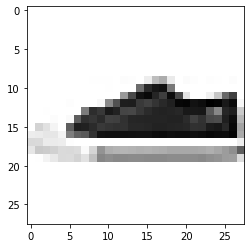

In [ ]:
# Quick convenient dictionary for mapping IDX to label

label_map = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


images, labels = next(iter(training_data_loader))
print(f"Note the shape of a single image: \n {images[0].shape}")
example_image = images[0].numpy().squeeze()
print(
    f"Post numpy and squeeze gives us a 28x28 matrix representation of our image with shape: \n    {example_image.shape}"
)
plt.imshow(example_image, cmap="gray_r")
print(f"this example image is a {label_map.get(labels[0].item())}")

### Okay enough belly-achin, let's test our work!

We create the neural network, select our criterion and optimizer, then load up the model and run training and evaluation.

* model: this is a FC-NN but any pytorch Squential neural network can work, as long as you can strip off the output layer
* criterion: the criterion the neural network is evaluated on. Here we use negative log-likelihood because we're doing classification.
* optimizer: the optimizer for training your neural net. We use stochastic gradient descent here. I've frequently had good experience using optim.Adam in other projects. When in doubt, cross-validate! Here we keep it basic.


In [ ]:
model = create_basic_neural_net_structure(hidden_sizes=[256, 128, 128])
criterion = (
    nn.NLLLoss()
)  # Negative log-likelihood loss which is used because we're doing classification
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

our_latest_and_greatest = cnn_oc_svm(model, criterion, optimizer)

our_latest_and_greatest.training(
    epochs=3, learning_rate=0.003, training_data_loader=training_data_loader
)

/home/erin/anaconda3/envs/cnn_oc_svm/lib/python3.8/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1 - Training loss: 0.8460309876879649
Epoch 2 - Training loss: 0.4634871239156357
Epoch 3 - Training loss: 0.4066933798732788
Training time (s): 38.09494972229004


0.4066933798732788


Training took ~30s on an i7-8565U with 24gb ram and no GPU.

The evaluation results show we get ~84.4% accuracy. For reference average human performance with no fashion experience is about 83.5%, so we're already doing better than people!

This also has the similar performance as:
* Random forest classifiers (n_estimators of 50 or 100, max_depth = 10)
* Logistic Regression (l1 penalty and multi_class is 'ovr')

In [ ]:
our_latest_and_greatest.evaluation(validation_data_loader)

Images tested: 10000 
 Classification Accuracy: 0.8438


0.8438

## Training the OC-SVM on our training data

In [ ]:
our_latest_and_greatest.train_oc_svm(training_data_loader)
# training_data_loader.dataset.transform

Fitting One Class SVM on 60032 data points
OC SVM Sucessfully fit, training time: 714.6767659187317


In [ ]:
oc_svm_evaluation_data = datasets.MNIST(
    ".", train=False, transform=image_preprocessing_pipeline, download=True
)
oc_svm_evaluation_data_loader = torch.utils.data.DataLoader(
    oc_svm_evaluation_data, batch_size=64, shuffle=True
)

In [ ]:
results = our_latest_and_greatest.predict_if_outlier(oc_svm_evaluation_data_loader)

In [ ]:
right, wrong = np.unique(results, return_counts=True)[1]

In [ ]:
right / (wrong + right) * 100

6.25

In [ ]:
right

4